![MLComp](https://raw.githubusercontent.com/catalyst-team/catalyst-pics/master/pics/MLcomp.png)
![Catalyst](https://raw.githubusercontent.com/catalyst-team/catalyst-pics/master/pics/catalyst_logo.png)

### Plan:

1. Basic setup and short discussion about MLComp and Catalyst libraries

2. MLComp and Catalyst short tutorial

3. Severstal DAG execution. Due to Kaggle kernels limit, we will not train final models here. You should train them yourself locally. (the code is the same). All you need to do is to remove extra params from ```mlcomp dag``` command

Or you can download them https://www.kaggle.com/lightforever/severstalmodels

4. You can find inference here https://www.kaggle.com/lightforever/severstal-mlcomp-catalyst-infer-0-90672

**An ensemble of the segmentation models with a postprocessing gives 0.90672 on LB. If you add the classifier from Heng CherKeng's [thread](https://www.kaggle.com/c/severstal-steel-defect-detection/discussion/106462#latest-634450)**, you should get 0.9117 on LB**

## Basic setup

[MLComp](https://github.com/catalyst-team/mlcomp) is a distributed DAG (Directed acyclic graph) framework for machine learning with UI. It helps to train, manipulate, and visualize.

Every machine learning pipeline is a Directed acyclic graph. [MLComp](https://github.com/catalyst-team/mlcomp) helps to execute it in a parallel manner, see the results via Web UI and manipulate the process easily.

https://github.com/catalyst-team/mlcomp

[Catalyst](https://github.com/catalyst-team/catalyst) helps to train neural networks. It helps to get good positions in the competitions.

For an example, [yu4u and the others have finished at the 4th place using Catalyst](https://www.kaggle.com/c/recursion-cellular-image-classification/discussion/110337#latest-635296)

https://github.com/catalyst-team/catalyst

Install MLComp library. It already has Catalyst in the dependencies

In [1]:
%cd ~/Workspace/kaggle-2019Q3-steel/

/home/chengjiun/Workspace/kaggle-2019Q3-steel


In [24]:
! pip install mlcomp

Start MLComp's server

In [25]:
%%script bash --bg --out script_out

! mlcomp-server start

The sever has just started. If you run this code locally, you can open web browser and see the control panel: http://localhost:4201

Dags
![Dags](https://github.com/catalyst-team/mlcomp/raw/master/docs/imgs/dags.png)

Computers
![Computers](https://github.com/catalyst-team/mlcomp/raw/master/docs/imgs/computers.png)

Reports
![Reports](https://github.com/catalyst-team/mlcomp/raw/master/docs/imgs/reports.png)

We have no such an opportunity in a Kaggle kernel. But we can use MLComp's describe module. See below

## Catalyst/MLComp short tutorial

Catalyst has 2 API: 

1. python API, you are importing regular classes
2. config API, you are declaring an execution process in a special configuration file and run catalyst-dl run --config=PATH_TO_CONFIG

We use the second scenario. Let's have a look at our Catalyst config file

In [26]:
ls configs_kaggle

catalyst_kaggle.yml  kaggle.yml


In [27]:
cat configs_kaggle/catalyst_kaggle.yml

model_params:
  model: SegmentationModelPytorch
  num_classes: 4
  arch: Unet
  encoder: resnet34

args:
  expdir: "catalyst_segment_kaggle"
  logdir: "log"

stages:

  data_params:
    num_workers: 2
    batch_size: 36
    per_gpu_scaling: True
    img_folder: '../DATA/kaggle-2019Q3-steel/train_images/'
    mask_folder: '../DATA/kaggle-2019Q3-steel/train_masks/'
    fold_csv: '../DATA/kaggle-2019Q3-steel/masks.csv'
    fold_number: 0

  state_params:
    main_metric: dice
    minimize_metric: False

  criterion_params:
    criterion: BCEDiceLoss

  callbacks_params:
    loss:
      callback: CriterionCallback
    optimizer:
      callback: OptimizerCallback
    saver:
      callback: CheckpointCallback
    dice:
      callback: DiceCallback

  stage1:
    state_params:
      num_epochs: 360

    optimizer_params:
      optimizer: Adam
      lr: 0.001
      layerwise_params:
        model.encoder*:
          lr: 0.00001
        model.decoder*:
          lr: 0.001


SegmentationModelPytorch here is a wrapper of this library: https://github.com/qubvel/segmentation_models.pytorch

We are declaring a model, stages, callbacks, criterion, number of epochs, etc. in a special configuration file.

Then, we could run it via catalyst-dl run --config=../input/severstal/severstal/configs_kaggle/catalyst_kaggle.yml

But instead of if, we are declaring one additional config for [MLComp](https://github.com/catalyst-team/mlcomp).

[MLComp](https://github.com/catalyst-team/mlcomp) helps to declare DAG and execute it in a parallel.

In [12]:
cat configs_kaggle/kaggle.yml

info:
  name: kaggle_kernel
  project: severstal
  layout: segment
  expdir: ../
executors:
  preprocess:
    type: preprocess
  masks:
    type: masks
    depends: preprocess
  train:
    type: catalyst
    gpu: 1
    args:
      config: configs_kaggle/catalyst_kaggle.yml
    depends: masks
    trace: trace.pth
    grid:
      - - encoder: resnet34
        - encoder: se_resnext50_32x4d
          batch_size: 16
        - model_params:
            model: MobileUnet
            input_size: 256
            pretrained: True
            num_classes: 4
            layerwise_params: {}

You can see here:

1. basic info about DAG in info section

2. declaring DAG's structure in executors section.

DAG's element is known as Executor. They are here: preprocess, masks, train

Each executor must be declared somewhere in your project's folder where you are running ```mlcomp dag``` command

That is our project folder. Executors folder contains our executors.

Preprocess is a standard group K-Fold stratification

In [28]:
cat executors/preprocess.py

import pandas as pd

from mlcomp.contrib.split import stratified_group_k_fold
from mlcomp.worker.executors import Executor

BASE_DIR = '../DATA/kaggle-2019Q3-steel/'

@Executor.register
class Preprocess(Executor):
    def work(self):
        df = pd.read_csv(f'{BASE_DIR}/train.csv')
        df['exists'] = df['EncodedPixels'].notnull().astype(int)

        df['image_name'] = df['ImageId_ClassId'].map(
            lambda x: x.split('_')[0].strip()
        )
        df['class_id'] = df['ImageId_ClassId'].map(
            lambda x: int(x.split('_')[-1])
        )
        df['class_id'] = [
            row.class_id if row.exists else 0 for row in df.itertuples()
        ]
        df['fold'] = stratified_group_k_fold(
            label='class_id', group_column='image_name', df=df, n_splits=5
        )
        df.to_csv(f'TEMP/fold.csv', index=False)


if __name__ == '__main__':
    Preprocess().work()


masks converts masks from csv file to regular png masks

In [29]:
cat executors/masks.py

import os

import cv2
import pandas as pd
from tqdm import tqdm
import numpy as np

from mlcomp.contrib.transform.rle import rle2mask
from mlcomp.worker.executors import Executor
from executor.preprocess import BASE_DIR

@Executor.register
class Masks(Executor):
    def work(self) -> dict:
        df = pd.read_csv('TEMP/fold.csv')
        os.makedirs(f'{BASE_DIR}/train_masks', exist_ok=True)

        df = df.sort_values(by='ImageId_ClassId')
        size = (256, 1600)
        mask = np.zeros(size)
        res = []
        for row in tqdm(df.itertuples(), total=df.shape[0]):
            pixels = row.EncodedPixels
            if not isinstance(pixels, str):
                pixels = ''

            mask_cls = rle2mask(pixels, size[::-1])
            mask[mask_cls > 0] = row.class_id

            if row.ImageId_ClassId.endswith('_4'):
                img_id = row.ImageId_ClassId.split('.')[0].strip()
                cv2.imwrite(f'{BASE_DIR}/train_masks/{img_id}.png', mask)
                

train executor is a standard executor declared in MLComp library. That is a wrapper of Catalyst.

## Severstal DAG execution

Link Kaggle-specific folders

Start DAG

In [23]:
! sleep 5
! mlcomp dag configs_kaggle/kaggle.yml --params=~/Workspace/kaggle-2019Q3-steel/executors/train/params/data_params/max_count:50 --params=~/Workspace/kaggle-2019Q3-steel/executors/train/params/num_epochs:3

In [20]:
! mlcomp dag configs_kaggle/kaggle.yml

### IMPORTANT 

If you are running this code locally, run only ```mlcomp dag ../input/severstal/severstal/configs_kaggle/kaggle.yml```

This kernel provides a demo run only. With a limited number of samples and epochs.

Describe the DAG execution status

In [21]:
from mlcomp.utils.describe import describe, describe_task_names
describe_task_names(dag=1)

,id,name
0,1,preprocess
1,2,masks
2,3,encoder=resnet34
3,4,encoder=se_resnext50_32x4d batch_size=16
4,5,model_params/model=MobileUnet model_params/input_size=256 model_params/pretrained=True model_params/num_classes=4


If you run this kernel, you will see an auto-refreshing describe panel below. (otherwise, you see only the last plot)

2019-09-30 07:48:55.537197
Traceback (most recent call last):
  File "/home/chengjiun/Softwares/anaconda3/envs/tensorflow/lib/python3.6/site-packages/mlcomp/worker/tasks.py", line 243, in build
    self.download()
  File "/home/chengjiun/Softwares/anaconda3/envs/tensorflow/lib/python3.6/site-packages/mlcomp/worker/tasks.py", line 159, in download
    raise Exception(f'Executor = {executor_type} not found')
Exception: Executor = preprocess not found



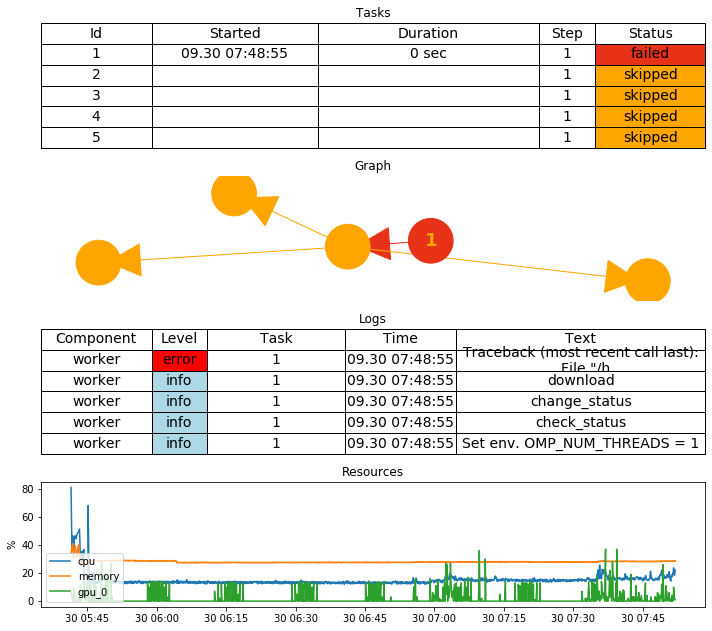

In [22]:
describe(dag=1, metrics=['loss', 'dice'], wait=True, task_with_metric_count=3, fig_size=(10 ,15))

#### Copy result models

Catalyst has a special mechanism named tracing. You can combine a model and that weights in as a single file.

We have done it, actually. ( we declared ```trace``` configuration for train executor).

All we need to do now, is to copy the result files.

In [ ]:
! cp ~/mlcomp/tasks/3/trace.pth unet_resnet34.pth
! cp ~/mlcomp/tasks/4/trace.pth unet_se_resnext50_32x4d.pth
! cp ~/mlcomp/tasks/5/trace.pth unet_mobilenet2.pth

### Conclusion

We have seen a short demonstration of MLComp/Catalyst execution process.

You can find inference here https://www.kaggle.com/lightforever/severstal-mlcomp-catalyst-infer-0-90672 